In [150]:
# import data
import pandas as pd
import numpy as np
df = pd.read_csv("Temperature_Anomaly_1880_2021.txt", header=None, delim_whitespace=True)
df.columns = ["year", "temp"]

C:\Users\aujo8\AppData\Local\Temp\ipykernel_30860\1093331669.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("Temperature_Anomaly_1880_2021.txt", header=None, delim_whitespace=True)


In [151]:
# data shape
print("Number of observations: ", df.shape[0], "\nNumber of features: ", df.shape[1])

# make sure data is sorted by year
df = df.sort_values(by='year')

# split data into training (1880-1980) and test (1981-2021)
train_origi = df.query('year < 1981').reset_index(drop=True)
test_origi = df.query('year > 1980').reset_index(drop=True)

print("\nTraining data tail:\n", train.tail(), "\n\nTest data head:\n", test.head())

Number of observations:  142 
Number of features:  2

Training data tail:
     year  temp_diff
95  1976      -0.09
96  1977       0.28
97  1978      -0.11
98  1979       0.10
99  1980       0.09 

Test data head:
    year  temp_diff
0  1981       0.06
1  1982      -0.18
2  1983       0.17
3  1984      -0.15
4  1985      -0.04


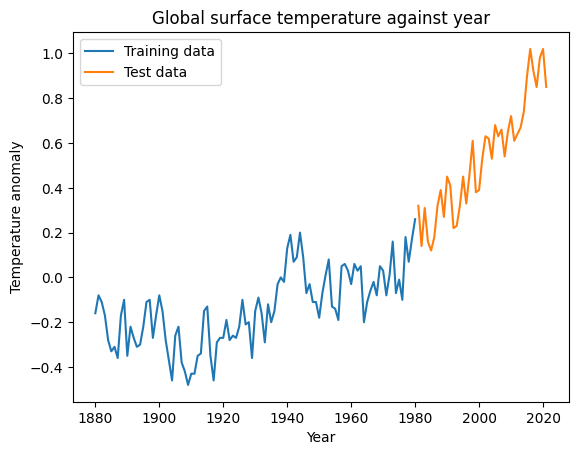

In [152]:
from matplotlib import pyplot as plt

plt.plot(train_origi["year"], train_origi["temp"], label="Training data")
plt.plot(test_origi["year"], test_origi["temp"], label="Test data")
plt.xlabel("Year")
plt.ylabel("Temperature anomaly")
plt.title("Global surface temperature against year")
plt.legend()

Obviously, this is not a stationary time-series and we therefore resort to transforming our variables to $y(t) = x(t) - x(t-1)$ as recommended in the description of the project. This leads to reduing the size of the training data by 1 as there is no way of creating a difference for the first data point.

In [153]:
# constructing the temperature difference time-series y(t)
temp_diff = [df["temp"][i] - df["temp"][i-1] for i in range(1, len(df["temp"]))]
year = df["year"][1:]
dict_diff = {'year':year, 'temp_diff':temp_diff}

df_diff = pd.DataFrame(dict_diff)
df_diff

,year,temp_diff
1,1881,0.08
2,1882,-0.03
3,1883,-0.06
4,1884,-0.11
5,1885,-0.05
...,...,...
137,2017,-0.10
138,2018,-0.07
139,2019,0.13
140,2020,0.04


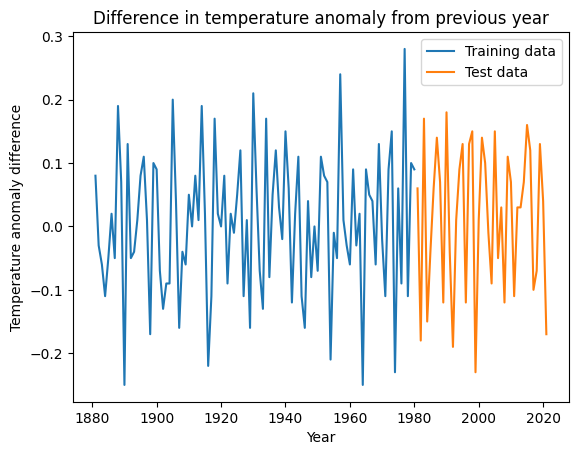

In [154]:
# rewrite train, test with new data
train = df_diff.query('year < 1981').reset_index(drop=True)
test = df_diff.query('year > 1980').reset_index(drop=True)

plt.plot(train["year"], train["temp_diff"], label="Training data")
plt.plot(test["year"], test["temp_diff"], label="Test data")
plt.xlabel("Year")
plt.ylabel("Temperature anomaly difference")
plt.title("Difference in temperature anomaly from previous year")
plt.legend()

We can see that, as opposed to the raw data, the difference-from-last-year time-series is now stationary, which allows for the application of RNN.

We now split the training data into predictors and targets, each predictor consisting of the $j$ yearly temperature differences preceding $y(t)$ (i.e. if $j = 3$ and $t = 5$, we then have the \{X,y\}-pair: \{\{y(2), y(3), y(4)\}, \{y(5)\}\}  

In [155]:
# length j of time-sequence acting as predictor
j = 5 # will most likely need some tuning

# split training and test data into predictors and targets based on j
X_train, y_train = [], []
X_test, y_test = [], []
for i in range(j, len(train['year'])):
    # training data
    X_train.append(train["temp_diff"][i-j : i])
    y_train.append(train["temp_diff"][i])

for i in range(j, len(test['year'])):
    # test data
    X_test.append(test["temp_diff"][i-j : i])
    y_test.append(test["temp_diff"][i])

# making into np arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [156]:
print("Predictors (train):\n", X_train[:4],"\n\nTargets (train):\n" , y_train[:4],
      "\n\nPredictors (test):\n", X_test[:4],"\n\nTargets (test):\n" , y_test[:4])

Predictors (train):
 [[ 0.08 -0.03 -0.06 -0.11 -0.05]
 [-0.03 -0.06 -0.11 -0.05  0.02]
 [-0.06 -0.11 -0.05  0.02 -0.05]
 [-0.11 -0.05  0.02 -0.05  0.19]] 

Targets (train):
 [ 0.02 -0.05  0.19  0.07] 

Predictors (test):
 [[ 0.06 -0.18  0.17 -0.15 -0.04]
 [-0.18  0.17 -0.15 -0.04  0.06]
 [ 0.17 -0.15 -0.04  0.06  0.14]
 [-0.15 -0.04  0.06  0.14  0.07]] 

Targets (test):
 [ 0.06  0.14  0.07 -0.12]


We can now start building up the architecture of the RNN.

In [157]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import *

In [ ]:
model = Sequential(
    [
        # first LSTM layer
        LSTM(units=32, input_shape=(X_train.shape[1], 1)),
        Dropout(0.05),

        # output layer
        Dense(units=1)
    ]
    
)

# compiling the model and choosing loss function
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fitting the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=32)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - loss: 0.0129 - val_loss: 0.0127
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0116 - val_loss: 0.0124
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0117 - val_loss: 0.0124
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0127 - val_loss: 0.0123
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0114 - val_loss: 0.0123
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0104 - val_loss: 0.0123
Epoch 10/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0121 - val_loss: 0.0122
Epoch 11/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 12/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0111 - val_l

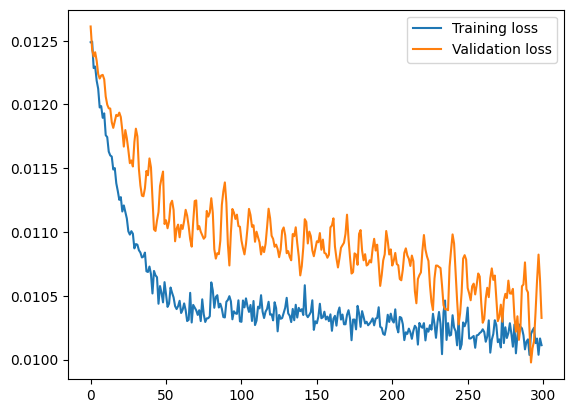

In [ ]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.show()

In [146]:
pred = model.predict(X_test)
pred

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


array([[ 0.06586023],
       [ 0.05003392],
       [-0.05527185],
       [-0.07007768],
       [-0.01105055],
       [-0.04440734],
       [-0.0383875 ],
       [ 0.06575467],
       [ 0.07889432],
       [ 0.00477206],
       [-0.04771736],
       [ 0.00809503],
       [-0.02776964],
       [-0.10302243],
       [ 0.00762266],
       [ 0.06104803],
       [-0.01933493],
       [-0.07852953],
       [-0.03218561],
       [ 0.00900418],
       [-0.02904999],
       [-0.0141365 ],
       [ 0.00422412],
       [ 0.05592151],
       [ 0.0061973 ],
       [-0.02407887],
       [ 0.01491371],
       [ 0.03549059],
       [-0.00082203],
       [-0.02388761],
       [-0.07894471],
       [-0.15949248],
       [-0.06899773],
       [ 0.02289483],
       [-0.01296384],
       [-0.03944356]], dtype=float32)

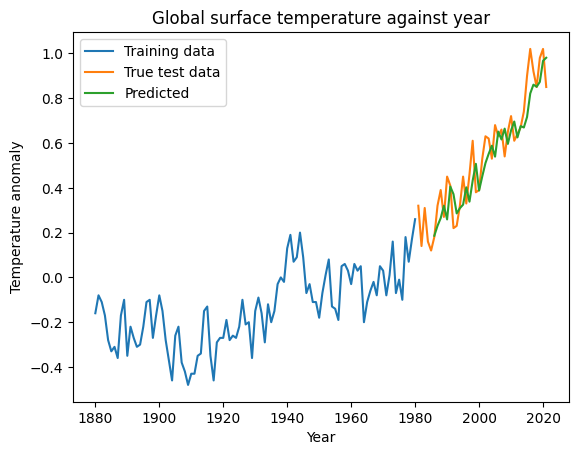

In [147]:
# transformin the differences back to original space
pred_origi = [pred[t-j] + test_origi["temp"][t-1] for t in range(j, len(test))]

plt.plot(train_origi["year"], train_origi["temp"], label="Training data")
plt.plot(test_origi["year"], test_origi["temp"], label="True test data")
plt.plot(test_origi["year"][j:], pred_origi, label="Predicted")
plt.xlabel("Year")
plt.ylabel("Temperature anomaly")
plt.title("Global surface temperature against year")
plt.legend()